# Сравнение методов классификации

In [1]:
!kaggle datasets download -d wenruliu/adult-income-dataset

Dataset URL: https://www.kaggle.com/datasets/wenruliu/adult-income-dataset
License(s): unknown
  0% 0.00/652k [00:00<?, ?B/s]
100% 652k/652k [00:00<00:00, 76.5MB/s]


In [2]:
import zipfile
with zipfile.ZipFile('/content/adult-income-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay

Возьмем датасет Adult income с Kaggle. Описание датасета:

### Основные характеристики:
- **Целевая переменная**: Доход (`<=50K` или `>50K`).
- **Количество записей**: 48,842 (включая тренировочные и тестовые данные).
- **Количество признаков**: 14 (13 независимых переменных + целевая).
- **Признаки**:
  - `age`: Возраст.
  - `workclass`: Тип занятости (например, частный сектор, государственный сектор, безработный).
  - `education`: Уровень образования.
  - `marital-status`: Семейное положение.
  - `occupation`: Профессия.
  - `relationship`: Родственные отношения (например, супруг, ребенок).
  - `race`: Расовая принадлежность.
  - `sex`: Пол.
  - `capital-gain`: Прибыль от инвестиций.
  - `capital-loss`: Убытки от инвестиций.
  - `hours-per-week`: Количество рабочих часов в неделю.
  - `native-country`: Страна происхождения.
  

## Первичный анализ

Посмотрим на базовую информацию о датасете

In [85]:
data = pd.read_csv('adult.csv')

display(data.info())
display(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


None

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [86]:
display(data)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


Посмотрим, какие уникальные значения у каждого класса присутствуют в датасете.

In [87]:
print('workclass',data.workclass.unique())
print('education',data.education.unique())
print('marital-status',data['marital-status'].unique())
print('occupation',data.occupation.unique())
print('relationship',data.relationship.unique())
print('race',data.race.unique())
print('gender',data.gender.unique())
print('native-country',data['native-country'].unique())
print('income',data.income.unique())

workclass ['Private' 'Local-gov' '?' 'Self-emp-not-inc' 'Federal-gov' 'State-gov'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
education ['11th' 'HS-grad' 'Assoc-acdm' 'Some-college' '10th' 'Prof-school'
 '7th-8th' 'Bachelors' 'Masters' 'Doctorate' '5th-6th' 'Assoc-voc' '9th'
 '12th' '1st-4th' 'Preschool']
marital-status ['Never-married' 'Married-civ-spouse' 'Widowed' 'Divorced' 'Separated'
 'Married-spouse-absent' 'Married-AF-spouse']
occupation ['Machine-op-inspct' 'Farming-fishing' 'Protective-serv' '?'
 'Other-service' 'Prof-specialty' 'Craft-repair' 'Adm-clerical'
 'Exec-managerial' 'Tech-support' 'Sales' 'Priv-house-serv'
 'Transport-moving' 'Handlers-cleaners' 'Armed-Forces']
relationship ['Own-child' 'Husband' 'Not-in-family' 'Unmarried' 'Wife' 'Other-relative']
race ['Black' 'White' 'Asian-Pac-Islander' 'Other' 'Amer-Indian-Eskimo']
gender ['Male' 'Female']
native-country ['United-States' '?' 'Peru' 'Guatemala' 'Mexico' 'Dominican-Republic'
 'Ireland' 'Germany' 'Philippines' 

## Очистка, преобразование и визуализация данных

Видно, что в некоторых признаках есть пустые значения "?" (workclass, occupation, native-country). Заменим "?" на None и посмотрим, сколько пустых значений в датасете.

In [88]:
data.replace('?', np.nan, inplace=True)
print(data.isnull().sum())

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64


Не так много. Уберем все записи с пропусками

In [89]:
data.dropna(inplace=True)
print(data.shape)

(45222, 15)


Преобразуем признаки с большим количеством значений в болле общие категории. Начнем с образования:

In [90]:
data['education'] = data['education'].replace({
    'Preschool': 'dropout',
    '10th': 'dropout',
    '11th': 'dropout',
    '12th': 'dropout',
    '1st-4th': 'dropout',
    '5th-6th': 'dropout',
    '7th-8th': 'dropout',
    '9th': 'dropout',
    'HS-Grad': 'HighGrad',
    'HS-grad': 'HighGrad',
    'Some-college': 'CommunityCollege',
    'Assoc-acdm': 'CommunityCollege',
    'Assoc-voc': 'CommunityCollege',
    'Bachelors': 'Bachelors',
    'Masters': 'Masters',
    'Prof-school': 'Masters',
    'Doctorate': 'Doctorate'
})

Посмотрим на распределение получившихся значений

<Axes: xlabel='count', ylabel='education'>

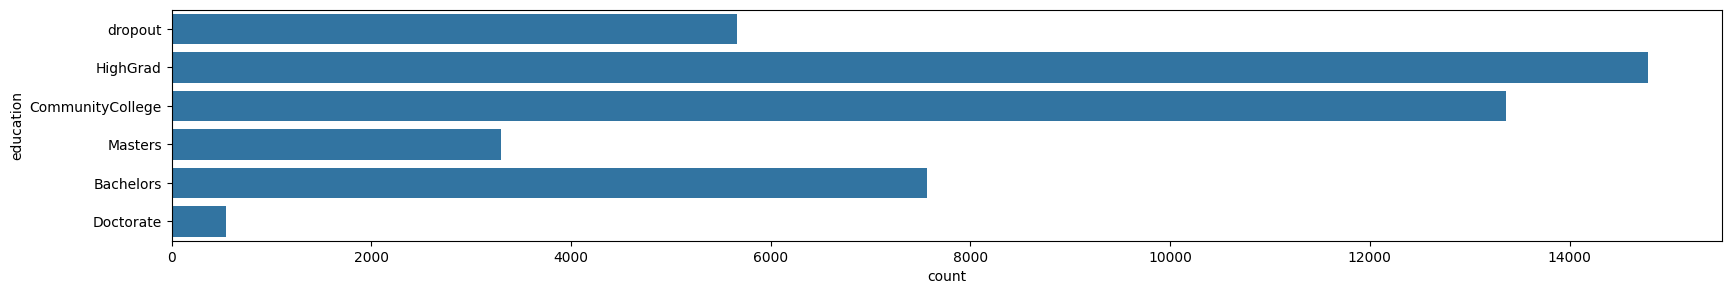

In [91]:
fig = plt.figure(figsize=(20,3))
sns.countplot(y="education", data=data)

Проделаем аналогичную операцию с статусом замужества:

In [92]:
data['marital-status'] = data['marital-status'].replace({
    'Never-married': 'NotMarried',
    'Married-AF-spouse': 'Married',
    'Married-civ-spouse': 'Married',
    'Married-spouse-absent': 'NotMarried',
    'Separated': 'Separated',
    'Divorced': 'Separated',
    'Widowed': 'Widowed'
})

Его распределение:

<Axes: xlabel='count', ylabel='marital-status'>

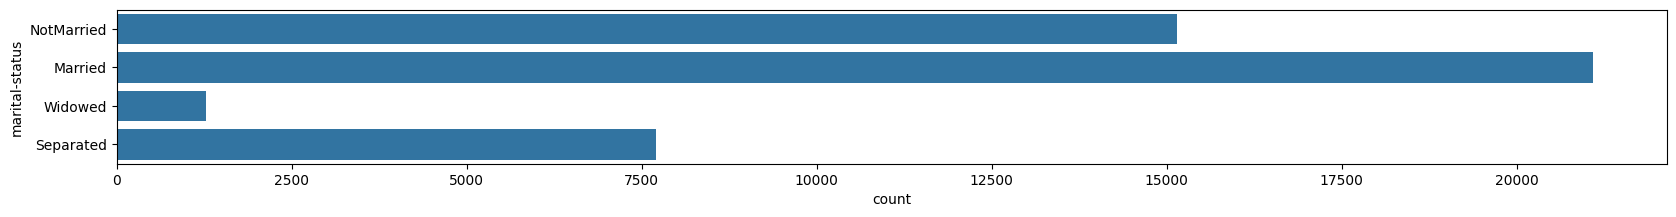

In [93]:
fig = plt.figure(figsize=(20,2))
sns.countplot(y="marital-status", data=data)

И для стран:

In [96]:
def categorize_country(country):
    if country in ['United-States', 'Canada', 'Outlying-US(Guam-USVI-etc)', 'Mexico']:
        return 'North America'
    elif country in ['Germany', 'England', 'Italy', 'France', 'Ireland', 'Scotland', 'Portugal', 'Greece', 'Holand-Netherlands', 'Poland', 'Hungary']:
        return 'Europe'
    elif country in ['Philippines', 'Japan', 'India', 'China', 'Vietnam', 'Cambodia', 'Thailand', 'Laos', 'Hong', 'Taiwan']:
        return 'Asia'
    elif country in ['Peru', 'Columbia', 'Guatemala', 'Dominican-Republic', 'El-Salvador', 'Haiti', 'Ecuador', 'Trinadad&Tobago', 'Jamaica']:
        return 'Latin America'
    elif country in ['South', 'Iran', 'Cambodia']:
        return 'Middle East'
    else:
        return 'Other'

data['native-region'] = data['native-country'].apply(categorize_country)
data.drop(columns='native-country', inplace=True)

In [ ]:
fig = plt.figure(figsize=(20,2))
sns.countplot(y="native-region", data=data)

Изучим, как признаки коррелируют между собой и с таргетом:

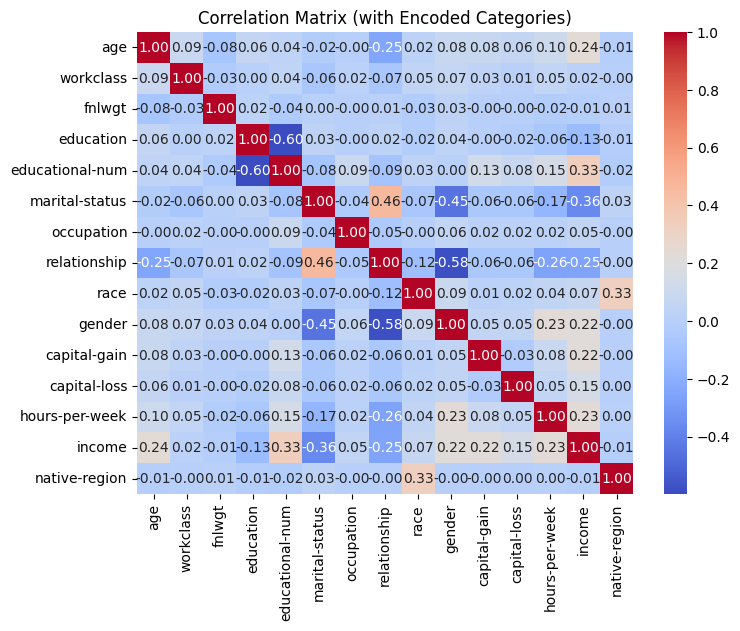

In [106]:
data_encoded = data.copy()
label_encoders = {}
for col in data.select_dtypes(include='object').columns:
    le = LabelEncoder()
    data_encoded[col] = le.fit_transform(data_encoded[col])
    label_encoders[col] = len

correlation_matrix = data_encoded.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (with Encoded Categories)")
plt.show()

Видно, что присутствуют признаки, слабо коррелирующие с таргетом. Поставим границу в 0.05 и уберем все признаки, слабо влияющие на значение целевой переменной

In [107]:
low_corr_threshold = 0.05

low_corr_features = correlation_matrix['income'][
    (correlation_matrix['income'].abs() < low_corr_threshold)
].index.tolist()

print(f"Признаки с низкой корреляцией с таргетом: {low_corr_features}")

data_encoded = data_encoded.drop(columns=low_corr_features)
data = data.drop(columns=low_corr_features)


Признаки с низкой корреляцией с таргетом: ['workclass', 'fnlwgt', 'occupation', 'native-region']


Разделим выборку на фичи и таргеты

In [109]:
X = data_encoded.drop('income', axis=1)
y = data_encoded['income']

Делим на трейн и тест

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)


Скалируем числовые признаки

In [108]:
cat_cols = data.select_dtypes(include=['object']).columns.drop('income')
num_cols = data.select_dtypes(include=[np.number]).columns

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

## Сравнение моделей

### Логичстическая регрессия

In [112]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'max_iter': [100, 200, 300],
    'penalty': ['l2']
}
lr = LogisticRegression(random_state=42)
grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train, y_train)
best_lr = grid_lr.best_estimator_
print("Лучшая модель LogisticRegression:", grid_lr.best_params_)
print("Accuracy на тесте LR:", accuracy_score(y_test, best_lr.predict(X_test)))


Лучшая модель LogisticRegression: {'C': 10, 'max_iter': 100, 'penalty': 'l2'}
Accuracy на тесте LR: 0.8357103372028745


### Дерево решений

In [113]:
param_grid_dt = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy', 'log_loss']
}
dt = DecisionTreeClassifier(random_state=42)
grid_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_dt.fit(X_train, y_train)
best_dt = grid_dt.best_estimator_
print("Лучшая модель DecisionTree:", grid_dt.best_params_)
print("Accuracy на тесте DT:", accuracy_score(y_test, best_dt.predict(X_test)))


Лучшая модель DecisionTree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}
Accuracy на тесте DT: 0.8509673852957435


### Ближайшие соседи

In [114]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train, y_train)
best_knn = grid_knn.best_estimator_
print("Лучшая модель KNN:", grid_knn.best_params_)
print("Accuracy на тесте KNN:", accuracy_score(y_test, best_knn.predict(X_test)))

Лучшая модель KNN: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Accuracy на тесте KNN: 0.8291873963515755


### Градиентный бустинг

In [115]:
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
gb = GradientBoostingClassifier(random_state=42)
grid_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='accuracy', n_jobs=-1)
grid_gb.fit(X_train, y_train)
best_gb = grid_gb.best_estimator_
print("Лучшая модель GradientBoosting:", grid_gb.best_params_)
print("Accuracy на тесте GB:", accuracy_score(y_test, best_gb.predict(X_test)))


Лучшая модель GradientBoosting: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Accuracy на тесте GB: 0.8630182421227197


Посчитаем метрики полученных моделей

In [118]:

models = {
    "Decision Tree": best_dt,
    "KNN": best_knn,
    "Logistic Regression": best_lr,
    "Gradient Boosting": best_gb
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Модель: {name}")
    print(f"balanced_accuracy на тестовой выборке: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))
    print("-" * 50)

Модель: Decision Tree
balanced_accuracy на тестовой выборке: 0.8510
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      6803
           1       0.78      0.56      0.65      2242

    accuracy                           0.85      9045
   macro avg       0.82      0.75      0.78      9045
weighted avg       0.84      0.85      0.84      9045

--------------------------------------------------
Модель: KNN
balanced_accuracy на тестовой выборке: 0.8292
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      6803
           1       0.68      0.58      0.63      2242

    accuracy                           0.83      9045
   macro avg       0.78      0.75      0.76      9045
weighted avg       0.82      0.83      0.82      9045

--------------------------------------------------
Модель: Logistic Regression
balanced_accuracy на тестовой выборке: 0.835

Построим матрицы ошибок полученных моделей

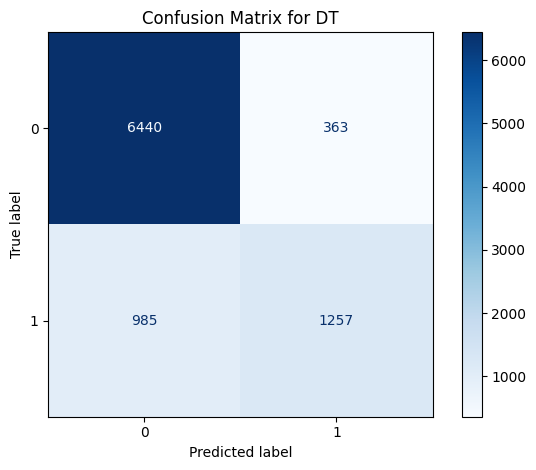

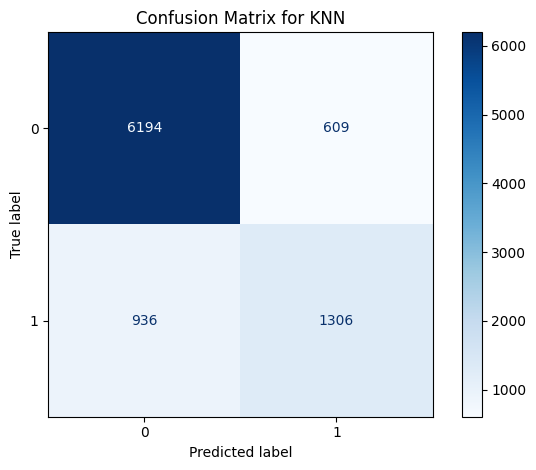

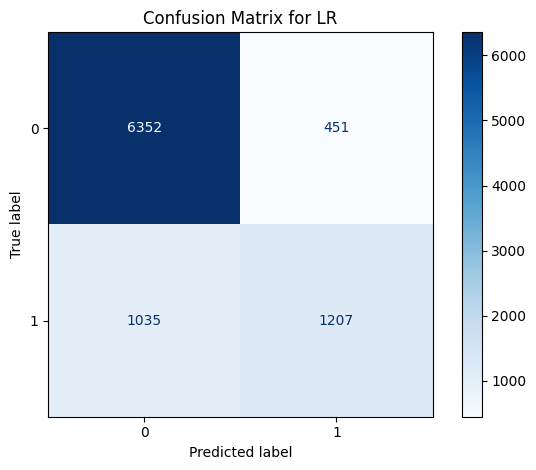

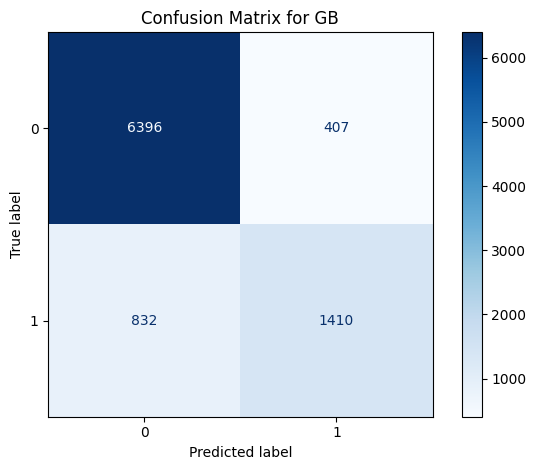

In [122]:
true_labels = [0, 1, 1, 0, 1, 0, 0, 1, 1, 0]
predictions = {
    "DT": best_dt.predict(X_test),
    "KNN": best_knn.predict(X_test),
    "LR": best_lr.predict(X_test),
    "GB": best_gb.predict(X_test),
}

def plot_confusion_matrix(true_labels, predictions, model_name):
    cm = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(true_labels))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.tight_layout()
    plt.show()

for model_name, model_predictions in predictions.items():
    plot_confusion_matrix(y_test, model_predictions, model_name)

## Вывод

Gradient Boosting показала наилучшие результаты с точностью 0.8630 и лучшими метриками для обоих классов. Decision Tree также хорош (balanced accuracy 0.8510), но уступает по полноте для класса 1. KNN и Logistic Regression хуже справляются с классом 1, их сбалансированная точность ниже (0.8292 и 0.8357). Для рассмотренной задачи лучше выбрать Gradient Boosting, так как она наиболее сбалансирована и эффективна.

Общая задача классификации была решена успешно, и модели продемонстрировали способность выделять ключевые закономерности в данных.